In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from pathlib import Path
import numpy as np
import pandas as pd
import os
from glob import glob
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from IPython.display import SVG

In [3]:
# add to use Graphviz
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

# Objective:

* Try and implement basic DL models using fastai v1 (code from 2019 course v3 DL1), Keras (what I know), Pytorch (learning)

## Project: Pet identifier

* Use Oxford-IIIT Pet Dataset by O. M. Parkhi et al., 2012 which features 12 cat breeds and 25 dogs breeds. Our model will need to learn to differentiate between these 37 distinct categories.

### Keras

In [4]:
import keras
from keras.models import Model, Sequential
from keras.optimizers import rmsprop, adam, SGD
from keras.layers import Dense, GlobalAveragePooling2D, Conv2D, Activation, MaxPooling2D, Dropout, Flatten
from keras.applications.resnet50 import ResNet50
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing.image import ImageDataGenerator
from keras_contrib.applications import resnet
from keras.utils.vis_utils import plot_model, model_to_dot

import tensorflow as tf
import GPUtil

Using TensorFlow backend.


In [5]:
keras.__version__

'2.2.4'

In [6]:
tf.__version__

'1.12.0'

#### Data Setup

In [7]:
# batch size
bs = 64

In [8]:
# main path where data is
path = Path(r"C:\Users\Shonket Ray\.fastai\data\oxford-iiit-pet")
path

WindowsPath('C:/Users/Shonket Ray/.fastai/data/oxford-iiit-pet')

In [9]:
# annotations and imgs paths
path_anno = path/'annotations'
path_img = path/'images'
print(path_anno, path_img)

C:\Users\Shonket Ray\.fastai\data\oxford-iiit-pet\annotations C:\Users\Shonket Ray\.fastai\data\oxford-iiit-pet\images


In [10]:
os.path.join(path_img, '*.jpg')

'C:\\Users\\Shonket Ray\\.fastai\\data\\oxford-iiit-pet\\images\\*.jpg'

In [11]:
pd.options.display.max_colwidth

50

In [12]:
# make df to use keras flow_from_dataframe
# https://medium.com/datadriveninvestor/keras-imagedatagenerator-methods-an-easy-guide-550ecd3c0a92
img_fullpaths = glob(os.path.join(path_img, '*.jpg'))
temp = [os.path.split(elem)[1].split('.')[0] for elem in img_fullpaths]
img_filenames = [os.path.split(elem)[1] for elem in img_fullpaths]
img_classes = ['_'.join(elem.split('_')[:-1]) for elem in temp]
#print(len(temp))

df = pd.DataFrame(zip(img_filenames, img_classes), columns=['filename', 'class'])
print(df.shape)

(7390, 2)


In [13]:
# view df head and counts
pd.options.display.max_colwidth = 100
df.head()

,filename,class
0,Abyssinian_1.jpg,Abyssinian
1,Abyssinian_10.jpg,Abyssinian
2,Abyssinian_100.jpg,Abyssinian
3,Abyssinian_101.jpg,Abyssinian
4,Abyssinian_102.jpg,Abyssinian


In [14]:
df.sample(20)

,filename,class
4505,newfoundland_194.jpg,newfoundland
2850,german_shorthaired_144.jpg,german_shorthaired
6781,Sphynx_80.jpg,Sphynx
5457,Russian_Blue_158.jpg,Russian_Blue
2897,german_shorthaired_187.jpg,german_shorthaired
2692,english_setter_182.jpg,english_setter
6624,Sphynx_130.jpg,Sphynx
5287,Ragdoll_189.jpg,Ragdoll
4071,Maine_Coon_176.jpg,Maine_Coon
2922,german_shorthaired_29.jpg,german_shorthaired


In [15]:
df.iloc[1000]

filename    Bengal_1.jpg
class             Bengal
Name: 1000, dtype: object

In [16]:
print(df['class'].nunique())
print(df['class'].value_counts().sort_index())

37
Abyssinian                    200
Bengal                        200
Birman                        200
Bombay                        200
British_Shorthair             200
Egyptian_Mau                  200
Maine_Coon                    200
Persian                       200
Ragdoll                       200
Russian_Blue                  200
Siamese                       200
Sphynx                        200
american_bulldog              200
american_pit_bull_terrier     200
basset_hound                  200
beagle                        200
boxer                         200
chihuahua                     200
english_cocker_spaniel        200
english_setter                200
german_shorthaired            200
great_pyrenees                200
havanese                      200
japanese_chin                 200
keeshond                      200
leonberger                    200
miniature_pinscher            200
newfoundland                  200
pomeranian                    200
pug        

In [17]:
# Create batch generators from df for training and validation data with real-time data aug.
datagen = ImageDataGenerator(validation_split=0.2, horizontal_flip=True)

# train_generator = train_datagen.flow_from_directory(
#         path_img,
#         target_size=(224, 224),
#         batch_size=bs, classes = list(temp))

train_generator = datagen.flow_from_dataframe(
    dataframe=df, 
    directory=path_img,
    x_col='filename',
    y_col='class', 
    subset="training",
    seed=41,
    target_size=(224, 224), 
    batch_size=bs, 
    class_mode='categorical')

valid_generator = datagen.flow_from_dataframe(
    dataframe=df, 
    directory=path_img,
    x_col='filename',
    y_col='class', 
    subset="validation",
    seed=42,
    target_size=(224, 224), 
    batch_size=bs, 
    class_mode='categorical')

Found 5912 images belonging to 37 classes.
Found 1478 images belonging to 37 classes.


In [18]:
valid_generator.class_indices
inv_map = {v: k for k, v in valid_generator.class_indices.items()}
print(inv_map)

{0: 'Abyssinian', 1: 'american_bulldog', 2: 'american_pit_bull_terrier', 3: 'basset_hound', 4: 'beagle', 5: 'Bengal', 6: 'Birman', 7: 'Bombay', 8: 'boxer', 9: 'British_Shorthair', 10: 'chihuahua', 11: 'Egyptian_Mau', 12: 'english_cocker_spaniel', 13: 'english_setter', 14: 'german_shorthaired', 15: 'great_pyrenees', 16: 'havanese', 17: 'japanese_chin', 18: 'keeshond', 19: 'leonberger', 20: 'Maine_Coon', 21: 'miniature_pinscher', 22: 'newfoundland', 23: 'Persian', 24: 'pomeranian', 25: 'pug', 26: 'Ragdoll', 27: 'Russian_Blue', 28: 'saint_bernard', 29: 'samoyed', 30: 'scottish_terrier', 31: 'shiba_inu', 32: 'Siamese', 33: 'Sphynx', 34: 'staffordshire_bull_terrier', 35: 'wheaten_terrier', 36: 'yorkshire_terrier'}


In [19]:
# grab sample batch from generator
#x_batch, y_batch = next(valid_generator)
x_batch, y_batch = next(train_generator)

In [20]:
# 3 channel imgs, hot-encoded labels
print(x_batch.shape, y_batch.shape)

(64, 224, 224, 3) (64, 37)


In [21]:
ind = 1

In [22]:
x_batch[ind].shape

(224, 224, 3)

In [23]:
x_batch[ind].dtype

dtype('float32')

In [24]:
y_batch[ind]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.], dtype=float32)

In [25]:
np.argmax(y_batch[ind])

12

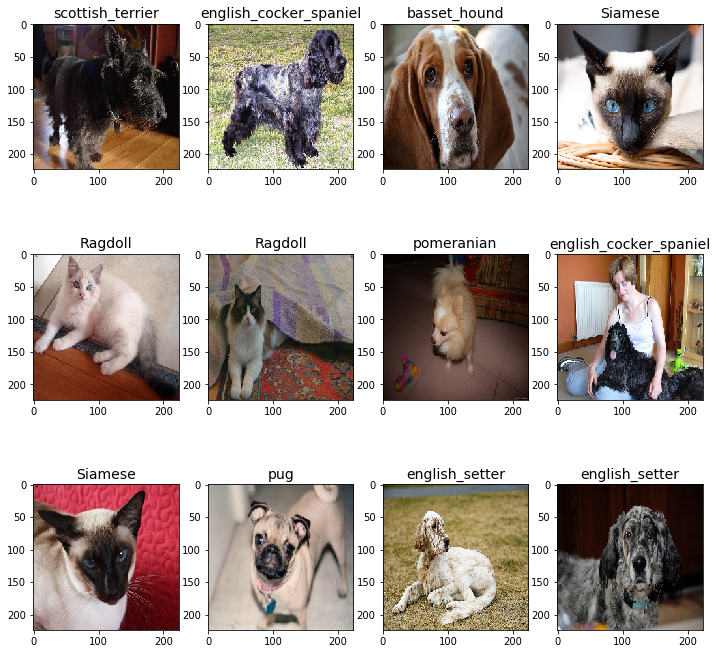

In [26]:
# show batch 
fig = plt.figure(figsize=(12,12))
gs = gridspec.GridSpec(3, 4, hspace=0.2, wspace=0.2)

for i in range(12):
    # need to change img dtype float32 to uint8 to show properly and not inverted colors
    img, label = x_batch[i].astype(np.uint8), np.argmax(y_batch[i])
    ax = plt.subplot(gs[i])
    ax.imshow(img)
    ax.set_title(inv_map[label], fontsize=14)
plt.show()

### Train model

In [28]:
GPUtil.showUtilization()

| ID | GPU | MEM |
------------------
|  0 |  2% | 17% |


In [29]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_batch.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(256, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(256, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
# model.add(Dense(512))
# model.add(Activation('relu'))
# model.add(Dropout(0.5))
model.add(Dense(37))
model.add(Activation('softmax'))

model.summary()

# initiate RMSprop optimizer
opt = rmsprop(lr=0.0001, decay=1e-6)

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size
print('Train Step size', STEP_SIZE_TRAIN, 'Validation Step size', STEP_SIZE_VALID)
history = model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=10
)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 32)      896       
_________________________________________________________________
activation_1 (Activation)    (None, 224, 224, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 222, 222, 32)      9248      
_________________________________________________________________
activation_2 (Activation)    (None, 222, 222, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 111, 111, 64)      18496     
__________

In [45]:
resnet_flag = 'inceptv3' # resnet34, resnet50, inceptionv3

if resnet_flag == '34':
    # this one has below layers
    base_model = resnet.ResNet34(input_shape=x_batch.shape[1:], classes=37)
    n = 2
elif resnet_flag == '50':        
    # create the base pre-trained model
    model_50 = ResNet50(input_shape=x_batch.shape[1:], weights='imagenet', include_top=False)

    # add a global spatial average pooling layer
    x = model_50.output
    x = GlobalAveragePooling2D()(x)
    # let's add a fully-connected layer
    x = Dense(1024, activation='relu')(x)
    # and a logistic layer -- let's say we have 37 classes
    predictions = Dense(37, activation='softmax')(x)

    # this is the model we will train
    base_model = Model(inputs=model_50.input, outputs=predictions)
    n = 3
elif resnet_flag == 'inceptv3':        
    # create the base pre-trained model
    model_incept = InceptionV3(input_shape=x_batch.shape[1:], weights='imagenet', include_top=False)

    # add a global spatial average pooling layer
    x = model_incept.output
    x = GlobalAveragePooling2D()(x)
    # let's add a fully-connected layer
    x = Dense(1024, activation='relu')(x)
    # and a logistic layer -- let's say we have 37 classes
    predictions = Dense(37, activation='softmax')(x)

    # this is the model we will train
    base_model = Model(inputs=model_incept.input, outputs=predictions)
    n = 3
    
# first: train only the top layers (freeze all convolutional layers)
for layer in base_model.layers[:-n]:
    layer.trainable = False

In [27]:
# create the base pre-trained model
# resnet50_model = ResNet50(weights='imagenet', include_top=False)

In [28]:
# resnet50_model.summary(line_length=115)

In [46]:
base_model.summary(line_length=115)

___________________________________________________________________________________________________________________
Layer (type)                         Output Shape              Param #       Connected to                          
input_3 (InputLayer)                 (None, 224, 224, 3)       0                                                   
___________________________________________________________________________________________________________________
conv2d_1 (Conv2D)                    (None, 111, 111, 32)      864           input_3[0][0]                         
___________________________________________________________________________________________________________________
batch_normalization_1 (BatchNormaliz (None, 111, 111, 32)      96            conv2d_1[0][0]                        
___________________________________________________________________________________________________________________
activation_99 (Activation)           (None, 111, 111, 32)      0        

In [30]:
# base_model.layers[-3].output_shape

In [31]:
# resnet50_model.layers[-1].output_shape

In [32]:
# base_model.layers[-1].get_weights()

In [33]:
# resnet50_model.layers[-1].get_weights()

In [47]:
base_model.compile(optimizer=adam(lr=0.01), loss="categorical_crossentropy", metrics=["accuracy"])

In [48]:
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size
print('Train Step size', STEP_SIZE_TRAIN, 'Validation Step size', STEP_SIZE_VALID)
history = base_model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=10
)

Train Step size 92 Validation Step size 23
Epoch 1/10
92/92 [==============================] - 44s 476ms/step - loss: 15.3442 - acc: 0.0344 - val_loss: 16.1181 - val_acc: 0.0000e+00
Epoch 2/10
92/92 [==============================] - 36s 395ms/step - loss: 15.5322 - acc: 0.0363 - val_loss: 16.1181 - val_acc: 0.0000e+00
Epoch 3/10
92/92 [==============================] - 36s 393ms/step - loss: 15.6007 - acc: 0.0321 - val_loss: 16.1181 - val_acc: 0.0000e+00
Epoch 4/10
92/92 [==============================] - 36s 395ms/step - loss: 15.6253 - acc: 0.0306 - val_loss: 16.1181 - val_acc: 0.0000e+00
Epoch 5/10
92/92 [==============================] - 36s 390ms/step - loss: 15.4912 - acc: 0.0389 - val_loss: 16.1181 - val_acc: 0.0000e+00
Epoch 6/10
92/92 [==============================] - 36s 390ms/step - loss: 15.5934 - acc: 0.0326 - val_loss: 16.1181 - val_acc: 0.0000e+00
Epoch 7/10
92/92 [==============================] - 36s 392ms/step - loss: 15.5715 - acc: 0.0339 - val_loss: 16.1181 - val_

In [49]:
# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(base_model.layers):
    print(i, layer.name)

0 input_3
1 conv2d_1
2 batch_normalization_1
3 activation_99
4 conv2d_2
5 batch_normalization_2
6 activation_100
7 conv2d_3
8 batch_normalization_3
9 activation_101
10 max_pooling2d_3
11 conv2d_4
12 batch_normalization_4
13 activation_102
14 conv2d_5
15 batch_normalization_5
16 activation_103
17 max_pooling2d_4
18 conv2d_9
19 batch_normalization_9
20 activation_107
21 conv2d_7
22 conv2d_10
23 batch_normalization_7
24 batch_normalization_10
25 activation_105
26 activation_108
27 average_pooling2d_1
28 conv2d_6
29 conv2d_8
30 conv2d_11
31 conv2d_12
32 batch_normalization_6
33 batch_normalization_8
34 batch_normalization_11
35 batch_normalization_12
36 activation_104
37 activation_106
38 activation_109
39 activation_110
40 mixed0
41 conv2d_16
42 batch_normalization_16
43 activation_114
44 conv2d_14
45 conv2d_17
46 batch_normalization_14
47 batch_normalization_17
48 activation_112
49 activation_115
50 average_pooling2d_2
51 conv2d_13
52 conv2d_15
53 conv2d_18
54 conv2d_19
55 batch_normaliz

In [50]:
plot_model(base_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

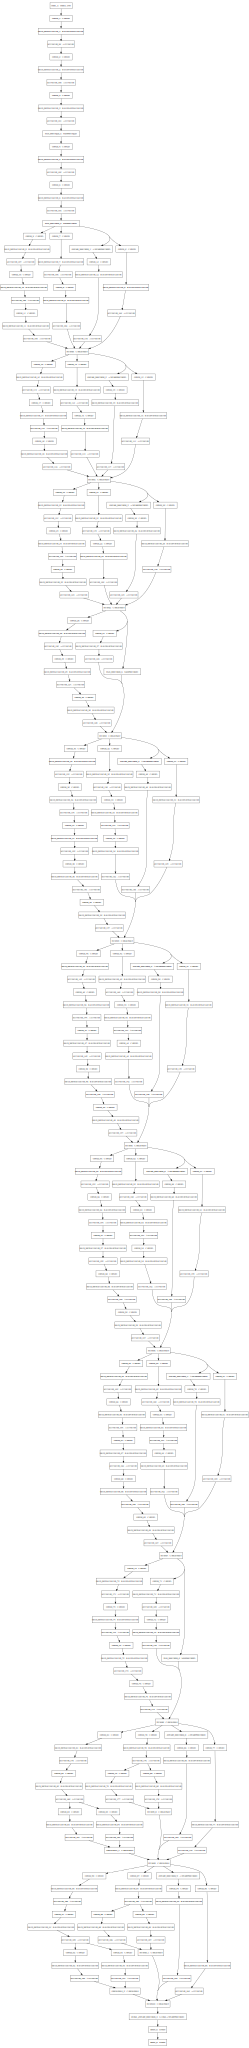

In [51]:
SVG(model_to_dot(base_model).create(prog='dot', format='svg'))

In [52]:
# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first n layers and unfreeze the rest:
if resnet_flag == '34':
    n = 101
elif resnet_flag == '50': 
    n = 121
elif resnet_flag == 'inceptv3': 
    n = 249

for layer in base_model.layers[:n]:
    layer.trainable = False
for layer in base_model.layers[n:]:
    layer.trainable = True

In [53]:
base_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 111, 111, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 111, 111, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_99 (Activation)      (None, 111, 111, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

c:\program files\python36\lib\site-packages\keras\engine\training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


In [54]:
# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
base_model.compile(optimizer=SGD(lr=0.01, momentum=0.9), loss='categorical_crossentropy', metrics=["accuracy"])

# we train our model again (this time fine-tuning the top blocks alongside the top Dense layers
history_2 = base_model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=30
)

Epoch 1/30
92/92 [==============================] - 49s 530ms/step - loss: 15.5880 - acc: 0.0329 - val_loss: 16.1181 - val_acc: 0.0000e+00
Epoch 2/30
92/92 [==============================] - 42s 455ms/step - loss: 15.5843 - acc: 0.0331 - val_loss: 16.1181 - val_acc: 0.0000e+00
Epoch 3/30
92/92 [==============================] - 42s 461ms/step - loss: 15.5569 - acc: 0.0348 - val_loss: 16.1181 - val_acc: 0.0000e+00
Epoch 4/30
92/92 [==============================] - 43s 464ms/step - loss: 15.5706 - acc: 0.0340 - val_loss: 16.1181 - val_acc: 0.0000e+00
Epoch 5/30
92/92 [==============================] - 43s 464ms/step - loss: 15.5797 - acc: 0.0334 - val_loss: 16.1181 - val_acc: 0.0000e+00
Epoch 6/30
92/92 [==============================] - 43s 465ms/step - loss: 15.5578 - acc: 0.0348 - val_loss: 16.1181 - val_acc: 0.0000e+00
Epoch 7/30
92/92 [==============================] - 43s 465ms/step - loss: 15.6308 - acc: 0.0302 - val_loss: 16.1181 - val_acc: 0.0000e+00
Epoch 8/30
92/92 [=========

In [55]:
base_model.evaluate_generator(generator=valid_generator, steps=STEP_SIZE_VALID, verbose=1)

23/23 [==============================] - 8s 328ms/step


[16.11809539794922, 0.0]

In [56]:
valid_generator.reset()
pred = base_model.predict_generator(valid_generator, steps=STEP_SIZE_VALID, verbose=1)

23/23 [==============================] - 10s 417ms/step


In [57]:
predicted_class_indices=np.argmax(pred,axis=1)

In [103]:
predictions = [labels[k] for k in predicted_class_indices]

NameError: name 'labels' is not defined

In [58]:
predicted_class_indices[:40]

array([29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29,
       29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29,
       29, 29, 29, 29, 29, 29], dtype=int64)